In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Simulation Group Project1/

/content/drive/My Drive/Simulation Group Project1


In [ ]:
ls

 ay-run/
 GCF_000001405.40.zip
 gdac.broadinstitute.org_LUAD-TP.CopyNumber_Gistic2.Level_4.2016012800.0.0.tar.gz
 Homo_sapiens.gene_info.gz
 input/
 NBSS-master/
 NBS_test.ipynb
 __pycache__/
'Reference and Resources.docx'
'Simulation Group Project'@
 SRW_v044.py
 test/
 yzw-run/


In [ ]:
import pandas as pd
import pickle

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix, issparse
import functools
from multiprocessing import Pool, cpu_count
from numba import jit
import time

In [ ]:
def load_network(file_name, output_dir='', add_selfloop=True):
    # Load a graph
    print ("* Loading network...")
    df = pd.read_table(file_name)
    nfeatures = len(df.columns) - 2
    if add_selfloop:
        df['self_loop'] = 0.
    df['intercept'] = 1.
    node_set = set(df.iloc[:,0]) | set(df.iloc[:,1])

    node2index = {}
    nodes = []
    index_map = ''
    selfloop_list = []
    for i, node in enumerate(sorted(list(node_set))):
        node2index[node] = i
        nodes.append(node)
        index_map += '{}\t{}\n'.format(i, node)
        # Add self-loops
        if add_selfloop:
            selfloop_list.append([node, node] + [0.]*nfeatures + [1., 1.])
    if add_selfloop:
        selfloop_df = pd.DataFrame(selfloop_list, columns=df.columns)
        df = pd.concat([df, selfloop_df])

    if output_dir:
        # Set up an output directory
        print ("* Saving node list to file...")
        os.system('mkdir -p ' + output_dir)
        with open("{}/index_nodes".format(output_dir), 'w') as outfile:
            outfile.write( "\n".join(index_map) )

    edges = df.iloc[:,:2].applymap(lambda x: node2index[x]).values
    features = csc_matrix(df.iloc[:,2:].values)
    return edges, features, nodes

In [ ]:
edges, features, node_names = load_network('test/LUAD_edge2features_2.txt')

* Loading network...


In [ ]:
len(node_names)

489

In [ ]:
print(edges.shape, features.shape, len(node_names))

(5274, 2) (5274, 64) 489


In [ ]:
def load_samples(file_name, nodes, output_dir=''):
    df = pd.read_table(file_name, index_col=0)
    # df should be a sample by node matrix
    samples = df.index
    node_set = set(df.columns)&set(nodes)
    print ("\t- Nodes in adjacency matrix:", len(node_set))

    # Index mapping for samples
    sample2index = {samples[i]: i for i in range(len(samples))}
    if output_dir:
        # Set up output directory
        print ("* Saving sample list to file...")
        os.system( 'mkdir -p ' + output_dir)
        index_map = ["{}\t{}".format(i, samples[i]) for i in range(len(samples))]
        with open("{}/index_samples".format(output_dir), 'w') as outfile:
            outfile.write( "\n".join(index_map) )

    P_init = pd.DataFrame(index=df.index, columns=nodes)
    P_init.update(df)
    P_init = csr_matrix(P_init.fillna(0).values)
    return P_init, samples

In [ ]:
P_init_train, sample_names_train = load_samples('test/LUAD_training_data_2.txt', node_names)

	- Nodes in adjacency matrix: 489


In [ ]:
P_init_val, sample_names_val = load_samples('test/LUAD_validation_data_2.txt', node_names)

	- Nodes in adjacency matrix: 489


In [ ]:
def load_grouplabels(file_name):
    group_labels = []
    with open(file_name) as f:
        lines = f.read().rstrip().splitlines()
        for i, line in enumerate(lines):

            if i == 0:
                continue
            row = line.split('\t')
            group_labels.append(row[1])
    return group_labels


In [ ]:
group_labels_train = load_grouplabels('test/LUAD_training_lables_2.txt')


In [ ]:
len(group_labels_train)

147

In [ ]:
group_labels_val = load_grouplabels('test/LUAD_validation_lables_2.txt')

In [ ]:
len(group_labels_val)

36

In [ ]:
nnodes = len(node_names)
rst_prob = 0.3
lam = 1e-1

In [ ]:
feature_names = []
with open('test/LUAD_feature_names_2.txt') as f:
    for line in f.read().rstrip().splitlines():
        feature_names.append(line)
feature_names.append('selfloop')
feature_names.append('intercept')

In [ ]:
len(feature_names)

64

In [ ]:
# Return the edge strength (e by 1) calculated by a logistic function
# Inputs: edge features (e by w) and edge feature weights (vector w)
def logistic_edge_strength(features, w):
    return  1.0 / (1+np.exp(-features.dot(w)))


# Calculate the gradient of edge strength functioin with
# respect to edge feature weights, returns a matrix of gradients (e by w)
# Equation: dStrength/dw = features * edge_strength * (1-edge_strength)
def logistic_strength_gradient(features, edge_strength):
    logistic_slop = np.multiply(edge_strength, (1-edge_strength))[:,np.newaxis]
    return features.multiply(logistic_slop)


# Normalize a matrix by row sums,
# return a normalized matrix
def renorm(M):
    return csr_matrix(M / (M.sum(axis=1)+1e-8))


# This function takes edges (e by 2), edge features (e by w),
# edge feature weights (vector w), and the number of nodes,
# then retruns a transition matrix Q (n by n), un-normalized
# transition matrix M_strength (n by n), row sums of M_strength (n by 1),
# and the gradient of edge strength (e by w)
# Note: (i, j) and (j, i) should be 2 rows in edges, with different features
def strength_Q_and_gradient(edges, nnodes, features, w):
    # Calculate edge strength and the gradient of strength
    edge_strength = logistic_edge_strength(features, w)
    strength_grad = logistic_strength_gradient(features, edge_strength)
    # M_strength (n by n) is a matrix containing edge strength
    # where M[i,j] = strength[i,j];
    M_strength = csr_matrix((edge_strength, (edges[:,0], edges[:,1])),
                            shape=(nnodes, nnodes))
    M_strength_rowSum = M_strength.sum(1)
    # Normalize the transition matrix
    Q = renorm(M_strength)
    return Q, M_strength, M_strength_rowSum, strength_grad


# This function generates a transition matrix Q (n by n)
# without calculating gradients
def generate_Q(edges, nnodes, features, w):
    # Calculate edge strength
    edge_strength = logistic_edge_strength(features, w)
    # M_strength (n by n) is a matrix containing edge strength
    # where M[i,j] = Strength[i,j];
    M_strength = csr_matrix((edge_strength, (edges[:,0], edges[:,1])),
                            shape=(nnodes, nnodes))
    Q = renorm(M_strength)
    return Q

# *** This function calculates unweighted Q
def generate_Q_unweighted(edges, nnodes):
    M_strength = csr_matrix(([1.]*len(edges), (edges[:,0], edges[:,1])),
                            shape=(nnodes, nnodes))
    # Normalize the transition matrix
    Q = renorm(M_strength)
    return Q


# Calculate the gradient of Q: Q_grad (n by n)
# with respect to one edge feature weight w[l]
# Equation: Q[i,j] = strength[i,j] / sum_over_k(strength[i,k]), thus
# dQ[i,j]/dw[l] = (dStrength[i,j]/dw[l]*(sum_over_k(strength[i,k]))
#                  -Strength[i,j]*(sum_over_k(dStrength[i,k]/dw[l])))
#                 / (sum_over_k(strength[i,k]))**2
# Here strength_grad (e by 1) is with respect to one edge feature weight w[l]
def Q_gradient_1feature(edges, nnodes, M_strength, M_strength_rowSum, strength_grad):
    # M_strength_grad (n by n) is a matrix containing the gradient of edge strength
    # where M_strength_grad[i,j] = strength_grad[i,j];
    M_strength_grad = csr_matrix((np.squeeze(strength_grad), (edges[:,0], edges[:,1])),
                                 shape=(nnodes, nnodes))
    M_strength_grad_rowSum = M_strength_grad.sum(axis=1)
    Q_grad = (M_strength_grad.multiply(M_strength_rowSum)
              -M_strength.multiply(M_strength_grad_rowSum)) / np.square(M_strength_rowSum)
    return csr_matrix(Q_grad)


# This is the allclose comparison for sparse matrices
def csr_allclose(a, b, rtol=1e-5, atol = 1e-8):
    c = np.abs(a-b) - rtol*np.abs(b)
    return c.max() <= atol


# This is the allclose comparison for numba.jit
@jit(nopython=True)
def jit_allclose(a, b, rtol=1e-5, atol = 1e-8):
    c = np.abs(a-b) - rtol*np.abs(b)
    return c.max() <= atol


# This function takes a normalized transition matrix Q (n by n),
# initial state P_init (m by n), and reset probability,
# then use iteration to find the personalized PageRank at convergence.
@jit(nopython=True)
def iterative_PPR(Q, P_init, rst_prob):
    # Q and P_init are already normalized by row sums
    # Takes P_init and a transition matrix to find the PageRank of nodes
    P = P_init.copy()
    rst_prob_P_init = rst_prob*P_init
    P_new =  (1-rst_prob)*np.dot(P, Q) + rst_prob_P_init
    while not(jit_allclose(P, P_new)):
        P = P_new
        P_new =  (1-rst_prob)*np.dot(P, Q) + rst_prob_P_init
    return P_new


# This function takes PPR scores P (m by n), transition matrix Q (n by n),
# and partial derivatives of Q (Q_grad (n by n))
# with respect to one edge feature weight w[l]
# and iteratively calculate the gradient of PPR scores P_grad (m by n)
# with respect to w[l] until converged
# Equation: P = (1-rst_prob)*P.*Q + rst_prob*P_init
# therefore dP/dw = (1-rst_prob) * (dP/dw.*Q+P.*dQ/dw)
def iterative_P_gradient_1feature(P, Q, Q_grad, rst_prob):
    # Initlalize P_grad to be all zeros. See below for P_grad_1_iter
    P_grad = csr_matrix(np.zeros(P.shape))
    P_dot_Qgrad = P.dot(Q_grad)
    P_grad_new = P_grad_1feature_1iter(rst_prob, P_grad, Q, P_dot_Qgrad)
    # Iteratively calculate P_grad until converged
    while not(csr_allclose(P_grad, P_grad_new)):
        P_grad = P_grad_new
        P_grad_new = P_grad_1feature_1iter(rst_prob, P_grad, Q, P_dot_Qgrad)
    return P_grad_new

# *** This function calculates P_grad for one iteration,
# which is called by iterative_P_gradient_1feature
def P_grad_1feature_1iter(rst_prob, P_grad, Q, P_dot_Qgrad):
    return (1-rst_prob) * (P_grad.dot(Q)+P_dot_Qgrad)


# This wrapper function first calculates Q_grad, and then P_grad
# with respect to one edge feature weitht w[l]
# This is called by the following function calc_P_grad_pool
# using multiprocessing.Pool
def calc_P_grad_1fea(edges, nnodes, M_strength, M_strength_rowSum, Q, P, rst_prob,
                     strength_grad):
    Q_grad = Q_gradient_1feature(edges, nnodes, M_strength, M_strength_rowSum,
                                 strength_grad)
    P_grad = iterative_P_gradient_1feature(P, Q, Q_grad, rst_prob)
    return P_grad


# This function calculate P_grad with respect to ALL edge feature weights
# using multiprocessing.Pool
# return a (w by m by n) array
def calc_P_grad_pool(edges, nnodes, M_strength, M_strength_rowSum, Q, P, rst_prob,
                     strength_grad, ncpus=-1):
    # Create a partial function of calc_P_grad_1fea, with only one free argument
    # strength_grad
    calc_P_grad_1fea_partial = functools.partial(calc_P_grad_1fea, edges, nnodes, M_strength,
                                                 M_strength_rowSum, Q, P, rst_prob)
    # Split strength_grad (e by w) into a list of vectors
    strength_grad_split = np.split(strength_grad.toarray(), strength_grad.shape[1], axis=1)

    # For each edge feature weight, calculate P_grad
    if ncpus <= 0:
        ncpus = cpu_count()
    n_processes = min(ncpus, len(strength_grad_split))
    pool = Pool(processes=n_processes)
    P_grad = pool.map(calc_P_grad_1fea_partial, strength_grad_split)
    pool.close()
    pool.join()

    # return a (w by m by n) array
    P_grad = np.array([i.toarray() for i in P_grad])
    return P_grad


####################################################################################################
# Below are cost functions and their gradients
####################################################################################################

# This is the WMW cost function and its gradient
# cost_u = 1 / (1+exp(-xu/b))
# where xu = (||(mi/mi-1)(pu-ci)||**2-||pu-cj||**2)
# where ci is u's true group center (excluding u), and cj is u's nearest neighboring group center
@jit(nopython=True)
def cost_func_and_grad_WMW(nfeatures, nsamples, ngroups, P, P_grad, C, C_grad, sample2groupid_list,
                           group2nsample_list, b=0.5):
    P_dot_PT = np.dot(P, P.T) # m by m
    P_dot_CT = np.dot(P, C.T) # m by g
    C_dot_CT = np.dot(C, C.T) # g by g
    P_dot_PgradT = np.zeros((nfeatures, nsamples, nsamples)) # w by m by m
    P_dot_CgradT = np.zeros((nfeatures, nsamples, ngroups)) # w by m by g
    C_dot_PgradT = np.zeros((nfeatures, ngroups, nsamples)) # w by g by m
    C_dot_CgradT = np.zeros((nfeatures, ngroups, ngroups)) # w by g by g
    for l in range(nfeatures):
        P_dot_PgradT[l,:,:] = np.dot(P, P_grad[l,:,:].T)
        P_dot_CgradT[l,:,:] = np.dot(P, C_grad[l,:,:].T)
        C_dot_PgradT[l,:,:] = np.dot(C, P_grad[l,:,:].T)
        C_dot_CgradT[l,:,:] = np.dot(C, C_grad[l,:,:].T)
    cost = 0.
    cost_grad = np.zeros(nfeatures)
    accuracy = 0.
    M_opponent = np.zeros((ngroups,ngroups))
    M_opponent_trunc = np.zeros((ngroups,ngroups))
    for u in range(nsamples):
        x_u = -2.
        i = sample2groupid_list[u]
        mi = group2nsample_list[i]
        frac_sq = np.square(mi/(mi-1)) # (mi/(mi-1))**2
        dist_ui = frac_sq*(P_dot_PT[u,u]-2*P_dot_CT[u,i]+C_dot_CT[i,i])
        j_min = i
        for j in range(ngroups):
            if j != i:
                # xu = ||(mi/mi-1)(pu-ci)||**2-||pu-cj||**2
                x_u_tmp = dist_ui - (P_dot_PT[u,u]-2*P_dot_CT[u,j]+C_dot_CT[j,j])
                if x_u_tmp > x_u:
                    x_u = x_u_tmp
                    j_min = j
        j = j_min
        M_opponent[i,j] += 1
        if x_u < 0.:
            accuracy += 1.
        else:
            M_opponent_trunc[i,j] += 1
        # cost_u = 1 / (1+exp(-xu/b))
        cost_u = 1. / (1+np.exp(-x_u/b))
        cost += cost_u
        # cost_grad_uij = 2/b*cost_u*(1-cost_u) * ((pu-ci).*(pu_grad-ci_grad)*(mi/(mi-1))**2-
        #                                          (pu-cj).*(pu_grad-cj_grad))
        cost_grad += 2./b*cost_u*(1-cost_u) * ((P_dot_PgradT[:,u,u]
                                                -P_dot_CgradT[:,u,i]
                                                -C_dot_PgradT[:,i,u]
                                                +C_dot_CgradT[:,i,i])*frac_sq
                                               -(P_dot_PgradT[:,u,u]
                                                 -P_dot_CgradT[:,u,j]
                                                 -C_dot_PgradT[:,j,u]
                                                 +C_dot_CgradT[:,j,j]))
    return cost, cost_grad, accuracy, M_opponent, M_opponent_trunc

# This is the WMW cost function (for the validation set)
@jit(nopython=True)
def cost_func_WMW(nsamples, ngroups, P, C, sample2groupid_list, b=0.5):
    P_dot_CT = np.dot(P, C.T) # m by g
    C_dot_CT = np.dot(C, C.T) # g by g
    cost = 0.
    accuracy = 0.
    for u in range(nsamples):
        x_u = -2.
        i = sample2groupid_list[u]
        dist_ui = -2*P_dot_CT[u,i] + C_dot_CT[i,i]
        for j in range(ngroups):
            if j != i:
                # xu = ||pu-ci||**2-||pu-cj||**2
                x_u_tmp = dist_ui + 2*P_dot_CT[u,j] - C_dot_CT[j,j]
                if x_u_tmp > x_u:
                    x_u = x_u_tmp
        if x_u < 0:
            accuracy += 1.
        # cost_u = 1 / (1+exp(-xu/b))
        cost_u = 1. / (1+np.exp(-x_u/b))
        cost += cost_u
    return cost, accuracy

# This function calculates the confusion matrix
@jit(nopython=True)
def calc_confusion_matrix(nsamples, ngroups, P, C, sample2groupid_list):
    P_dot_CT = np.dot(P, C.T) # m by g
    C_dot_CT = np.dot(C, C.T) # g by g
    confusion_matrix = np.zeros((ngroups,ngroups))
    for u in range(nsamples):
        i = sample2groupid_list[u]
        j_min = i
        dist_min = 2.
        for j in range(ngroups):
            dist_uj = -2*P_dot_CT[u,j] + C_dot_CT[j,j]
            if dist_uj < dist_min:
                j_min = j
                dist_min = dist_uj
        j = j_min
        confusion_matrix[i,j] += 1
    return confusion_matrix


####################################################################################################
# These are functions used in the building stage of the SRW class
####################################################################################################

# This function returns a list of group indeces and a list of sample-group mapping
def sample_groupid_args(group_labels):
    grouplabel2index = {}
    for i, group in enumerate(sorted(list(set(group_labels)))):
        grouplabel2index[group] = i

    ngroups = len(grouplabel2index)
    nsamples = len(group_labels)
    group2indeces_list = [[] for _ in range(ngroups)]
    sample2groupid_list = []
    group2nsamples_list = [0. for _ in range(ngroups)]
    for u in range(nsamples):
        i = grouplabel2index[group_labels[u]]
        group2indeces_list[i].append(u)
        sample2groupid_list.append(i)
        group2nsamples_list[i] += 1
    return group2indeces_list, sample2groupid_list, group2nsamples_list


####################################################################################################
# These functions are used by the gradient descent function to update parameters
####################################################################################################

# This is a wrapper function for updating parameters, called by SRW.train_SRW_GD
def update_w(func, w, J_grad, learning_rate, m, n, t, PI_mu_t, v, **kwargs):
    if func == 'Nadam':
        w, m, n, PI_mu_t = update_w_Nadam(w, J_grad, learning_rate, m, n,
                                                      t, PI_mu_t, **kwargs)
    elif func == 'Adam':
        w, m, n = update_w_Adam(w, J_grad, learning_rate, m, n, t, **kwargs)
    elif func == 'Nesterov':
        w, v = update_w_Nesterov_momentum(w, J_grad, learning_rate, v, **kwargs)
    elif func == 'momentum':
        w, v = update_w_momentum(w, J_grad, learning_rate, v, **kwargs)
    return w, v, m, n, PI_mu_t


# This function uses momentum to accelerate gradient descent
def update_w_momentum(w, J_grad, learning_rate, v, momentum=0.9):
    v = momentum*v - learning_rate*J_grad
    w += v
    return w, v

# This is a better version of momentum (Nesterov 1983).
# See Geoffrey Hinton's lecture notes for details:
# http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
def update_w_Nesterov_momentum(w, J_grad, learning_rate, v, momentum = 0.9):
    v_prev = v.copy()
    v = momentum*v - learning_rate*J_grad
    # w is the position where we made a big (gamble) jump last time, then we
    # 1. move w back to where it was: -momentum*v_prev
    # 2. follow the new v vector to where it should be: +v
    # 3. make another gamble: +momentum*v
    # so the returned value w is actually w_ahead,
    # which should be close to w when learning converges
    w += -momentum*v_prev +v +momentum*v
    return w, v

# Adam(Adaptive Moment Estimation)
# See here for details:
# http://cs231n.github.io/neural-networks-3/#ada
def update_w_Adam(w, J_grad, learning_rate, m, n, t, eps=1e-8, beta1=0.9, beta2=0.999):
    m = beta1*m + (1-beta1)*J_grad #  first moment estimate
    m_hat = m / (1-beta1**t) # bias-corrected first moment estimate
    n = beta2*n + (1-beta2)*np.square(J_grad) # second moment estimate
    n_hat = n / (1-beta2**t) # bias-corrected second moment estimate
    w += -learning_rate*m_hat / (np.sqrt(n_hat)+eps)
    return w, m, n

# Nadam (Nesterov-accelerated adaptive moment estimation)
# http://cs229.stanford.edu/proj2015/054_report.pdf
def update_w_Nadam(w, J_grad, learning_rate, m, n, t, PI_mu_t, eps=1e-8, beta1=0.99, beta2=0.999):
    # Calculate the momentum schecule
    mu_t = beta1 * (1-0.5*0.96**(t/250))
    mu_next = beta1 * (1-0.5*0.96**((t+1)/250))
    PI_mu_t = PI_mu_t * mu_t
    PI_mu_next = PI_mu_t * mu_next

    J_grad_hat = J_grad / (1-PI_mu_t)
    m = beta1*m + (1-beta1)*J_grad # same as Adam
    m_hat = m / (1-PI_mu_next)
    n = beta2*n + (1-beta2)*np.square(J_grad) # same as Adam
    n_hat = n / (1-beta2**t) # same as Adam
    m_bar = mu_next*m_hat + (1-mu_t)*J_grad_hat # Nesterov
    w += -learning_rate*m_bar / (np.sqrt(n_hat)+eps)
    return w, m, n, PI_mu_t


####################################################################################################
# The Supervised Random Walk class
####################################################################################################

class SRW_solver(object):
    # Initialize global variables
    def __init__(self, edges, features, nnodes, P_init, rst_prob, group_labels, lam, w_init_sd=0.01,
                 w=None, feature_names=[], sample_names=[], node_names=[], loss='WMW',
                 norm_type='L1', learning_rate=0.1, update_w_func='Adam', P_init_val=None,
                 group_labels_val=None, ncpus=-1, maxit=1000, early_stop=None, WMW_b=2e-4):
        self.edges = edges                 # Edges in the network (e by 2, int, ndarray)
        self.features = features           # Edge features (e by w, float, csc_matrix)
        self.nnodes = nnodes               # Number of nodes in the network (int)
        self.P_init = P_init               # Initial state of training samples (m by n, float, csr_matrix)
        self.rst_prob = rst_prob           # reset probability of Random Walk (float)
        self.group_labels = group_labels   # Group labels of training samples (m by 1, str/int, list)
        self.lam = lam                     # Regularization parameter for controlling L1/L2 norm (float)
        self.w_init_sd = w_init_sd         # Standard deviation for weight initialization (float)
        self.loss = loss                   # Type of the loss funtion {'WMW'}
        self.norm_type = norm_type         # Type of the norm {'L1', 'L2'}
        self.learning_rate = learning_rate # Learning rate (float)
        self.update_w_func = update_w_func # Function for updating parameters {'momentum', 'Nesterov', 'Adam', 'Nadam'}
        self.P_init_val = P_init_val       # Initial state of validation samples (m by n, float, csr_matrix)
        self.group_labels_val = group_labels_val # Group labels of validation samples (m by 1, str/int, list)

        # This part creat some lists for calculating group centroids
        (self.group2indeces_list, self.sample2groupid_list,
         self.group2nsamples_list) = sample_groupid_args(group_labels)
        # Validation set
        if (P_init_val is not None) and (group_labels_val is not None):
            (self.group2indeces_list_val, self.sample2groupid_list_val,
             self.group2nsamples_list_val) = sample_groupid_args(group_labels_val)
            self.nsamples_val = len(group_labels_val)
            self.ngroups_val = len(self.group2indeces_list_val)

        # Number of samples, groups and features
        self.nsamples = len(group_labels)
        self.ngroups = len(self.group2indeces_list)
        self.nfeatures = features.shape[1]

        # Initialize weights
        self.w = w
        if w is None:
            self.init_w()

        # Node, feature and sample names
        self.node_names = node_names
        self.feature_names = feature_names
        self.sample_names = sample_names

        # Cost, accuracy, and silhouette width of training and validation set
        self.cost = None
        self.accuracy = None
        self.cost_val = None
        self.accuracy_val = None
        self.cost_list=[]
        self.accuracy_list=[]
        self.accuracy_val_list=[]

        # Record weights and cost of validation set for each iteration
        self.cost_val_list = []
        self.w_list = []

        self.ncpus = ncpus # Number of CPUs for multiprocessing.Pool
        self.maxit = maxit # Maximum iteration
        self.early_stop = early_stop # Early stop if the validation cost didn't improve in x iterations

        # Record the nearst neighboring group
        self.M_opponent = []
        self.M_opponent_trunc = []

        self.C = None # Group centroids of the training set
        self.Q = None # Transition matrix

        self.WMW_b = WMW_b # Parameter b in the WMW loss function


    # Initialize edge feature weights from a Gaussian distribution,
    # with standard deviation w_init_sd
    def init_w(self):
        self.w = np.random.normal(scale=self.w_init_sd, size=self.nfeatures)


    # This function maps edge feature weights with their names
    def map_w(self):
        if len(self.feature_names) == len(self.w):
            self.w_map = pd.DataFrame(self.w, index=self.feature_names, columns=['Weight'])
        else:
            self.w_map = pd.DataFrame(self.w, columns=['Weight'])


    # This function calculate group centroids and their gradients
    def centroid_and_grad(self, P, P_grad, ngroups_local, group2indeces_list_local):
        # Define a matrix C (g by n), which contains the group centroids
        C = np.zeros((ngroups_local, self.nnodes))
        # Define a matrix C_grad (w by g by n), which contains the gradient of group centroids
        C_grad = np.zeros((self.nfeatures, ngroups_local, self.nnodes))
        for i in range(ngroups_local):
            C[i,:] = P.take(group2indeces_list_local[i], axis=0).mean(axis=0)
            C_grad[:,i,:] = P_grad.take(group2indeces_list_local[i], axis=1).mean(axis=1)
        return C, C_grad


    # This function calculate group centroids
    def centroid(self, P, ngroups_local, group2indeces_list_local):
        C = np.zeros((ngroups_local, self.nnodes))
        for i in range(ngroups_local):
            C[i,:] = P.take(group2indeces_list_local[i], axis=0).mean(axis=0)
        return C


    # This is the objective function to be minimized, and its gradient
    # ** Objective function (scalar):
    # J = lam*||w||**2 + sum_over_u_and_v(y*sum((pu-pv)**2)/z_uv)
    # ** The gradient of the objective function (a vector with the length of w):
    # J_grad = lam*2*w + sum_over_u_and_v(y*(pu_grad-pv_grad).*(2*(pu-pv))/z_uv)
    # Inputs: P (m by n), P_grad (w by m by n)
    def obj_func_and_grad(self, P, P_grad, w_local):
        if issparse(P):
            P = P.toarray()

        # Compute cost from PPR scores
        # The cost is a scalar
        if self.loss == 'WMW':
            # cost_u = 1 / (1+exp(-xu/b)), where xu = (||pu-ci||**2-||pu-cj||**2)
            self.C, C_grad = self.centroid_and_grad(P, P_grad, self.ngroups, self.group2indeces_list)
            (self.cost, cost_grad, self.accuracy,
             M_opponent, M_opponent_trunc) = cost_func_and_grad_WMW(self.nfeatures, self.nsamples,
                                                                    self.ngroups, P, P_grad,
                                                                    self.C, C_grad,
                                                                    self.sample2groupid_list,
                                                                    self.group2nsamples_list,
                                                                    self.WMW_b)
            self.accuracy = self.accuracy / self.nsamples
            # print M_opponent
            # print M_opponent_trunc
            self.M_opponent.append(M_opponent)
            self.M_opponent_trunc.append(M_opponent_trunc)

        w_nob = w_local[:-1]
        if self.norm_type == 'L2':
            # Calculate the L2 norm squared of edge feature weights
            norm = np.dot(w_nob, w_nob)
            norm_grad = 2 * w_local
        elif self.norm_type == 'L1':
            # Calculate the L1 norm of edge feature weights
            norm = np.sum(np.abs(w_nob))
            norm_grad = np.sign(w_local)
        norm_grad[-1] = 0

        J = self.lam*norm + self.cost
        J_grad = self.lam*norm_grad + cost_grad

        return J, J_grad


    # This function calculates the cost for the validation set
    def calc_cost_val(self, P):
        if self.loss == 'WMW':
            self.cost_val, self.accuracy_val = cost_func_WMW(self.nsamples_val,
                                                             self.ngroups_val, P, self.C,
                                                             self.sample2groupid_list_val,
                                                             self.WMW_b)
            self.accuracy_val = self.accuracy_val / self.nsamples_val


    # This wrapper function sequentially calculate Q, Q_grad, P, P_grad to derive J and J_grad
    def calculate_J_and_gradient(self, w_local):
        # Generate transition matrix Q (n by n), edge strength matrix (n by n), its row sums (n by 1),
        # and gradient of edge strength (e by w) according to edge features and weights
        self.Q, M_strength, M_strength_rowSum, strength_grad = strength_Q_and_gradient(self.edges,
                                                                                       self.nnodes,
                                                                                       self.features,
                                                                                       w_local)
        print ('finished calculating strength_grad:', time.strftime("%H:%M:%S"))

        # Calculate Personalized PageRank (PPR)
        P = csr_matrix(iterative_PPR(self.Q.toarray(), renorm(self.P_init).toarray(), self.rst_prob))
        print ('finished network propagation:', time.strftime("%H:%M:%S"))

        # Calculate the gradient of PPR (w by m by n)
        P_grad = calc_P_grad_pool(self.edges, self.nnodes, M_strength, M_strength_rowSum, self.Q, P,
                                  self.rst_prob, strength_grad, self.ncpus)
        print ('finished calculating P_grad using pool:', time.strftime("%H:%M:%S"))

        # Calculate objective function J (scalar),
        # and its gradient J_grad (length w vector)
        J, J_grad = self.obj_func_and_grad(P, P_grad, w_local)
        print ('finished calculating J and J_grad:', time.strftime("%H:%M:%S"))

        return J, J_grad


    # This wrapper function calculates the cost and accuracy for the validation set
    def calc_cost_and_acc_val(self):
        if self.P_init_val is not None:
            P_val = iterative_PPR(self.Q.toarray(), renorm(self.P_init_val).toarray(), self.rst_prob)
            self.calc_cost_val(P_val)


    # This wrapper function calculates J and J_grad and cost_val and accuracy_val
    def calc_J_Jgrad_wrapper(self, w_local, t):
        J, J_grad = self.calculate_J_and_gradient(w_local)
        self.calc_cost_and_acc_val()
        print ('***', t, 'iteration: J is', J, 'cost_val is', self.cost_val)
        print ('*** accuracy is', self.accuracy, 'accuracy_val is', self.accuracy_val)
        # print w_local, '\n'
        print ('\n')
        self.cost_list.append(self.cost)
        self.cost_val_list.append(self.cost_val)
        self.accuracy_list.append(self.accuracy)
        self.accuracy_val_list.append(self.accuracy_val)
        self.w_list.append(w_local.copy())
        return J, J_grad


    # * This is the main function
    # This function trains the edge feature weights of Supervised Random Walk
    # using gradient descent functions
    def train_SRW_GD(self, **kwargs):
        # Initialize the velocity of w, used for momentum methods
        v = np.zeros(self.w.shape)
        # Initialize the first and second moment estimate of J_grad, used for Adam
        m = np.zeros(self.w.shape)
        n = np.zeros(self.w.shape)
        # Initialize the momentum schecule PI_mu_t, used for Nadam
        PI_mu_t = np.array([1.])

        # t is the iteration counter
        t = 0
        # Calculate the initlal J, and J_grad
        J, J_grad = self.calc_J_Jgrad_wrapper(self.w, t)

        t += 1
        # Update w for the first time
        self.w, v, m, n, PI_mu_t = update_w(self.update_w_func, self.w, J_grad, self.learning_rate,
                                            m, n, t, PI_mu_t, v, **kwargs)
        # Update J and J_grad for the first time
        J_new, J_grad = self.calc_J_Jgrad_wrapper(self.w, t)

        while (not np.allclose(J, J_new)) and (t < self.maxit):
            t += 1
            J = J_new
            # Update w
            self.w, v, m, n, PI_mu_t = update_w(self.update_w_func, self.w, J_grad,
                                                self.learning_rate, m, n, t, PI_mu_t, v, **kwargs)
            # Update J and J_grad
            J_new, J_grad = self.calc_J_Jgrad_wrapper(self.w, t)


            if (self.early_stop is not None) and (t > self.early_stop):
                t_min = self.cost_val_list.index(min(self.cost_val_list))
                if t > t_min + self.early_stop:
                    self.w = self.w_list[t_min]
                    print(self.sample2groupid_list_val,self.group2indeces_list_val)
                    return self.cost_list, self.cost_val_list, self.accuracy_list, self.accuracy_val_list

        self.map_w()
        print(self.sample2groupid_list_val,self.group2indeces_list_val)
        return self.cost_list, self.cost_val_list, self.accuracy_list, self.accuracy_val_list


    # This function generate the final Q and P after the training
    def generate_Q_and_P_fin(self):
        self.Q_fin = generate_Q(self.edges, self.nnodes, self.features, self.w)
        self.P_fin = iterative_PPR(self.Q_fin.toarray(), renorm(self.P_init).toarray(),
                                   self.rst_prob)
        if len(self.node_names) == self.nnodes:
            self.Q_fin_df = pd.DataFrame(self.Q_fin.toarray(), index=self.node_names,
                                         columns=self.node_names)
            if len(self.sample_names) == self.nsamples:
                self.P_fin_df = pd.DataFrame(self.P_fin, index=self.sample_names,
                                             columns=self.node_names)

In [ ]:
SRW_obj = SRW_solver(edges, features, nnodes, P_init_train, rst_prob, group_labels_train, lam,
                         w_init_sd=0.01, w=None, feature_names=feature_names,
                         sample_names=sample_names_train, node_names=node_names, loss='WMW',
                         norm_type='L1', learning_rate=0.1, update_w_func='Adam',
                         P_init_val=P_init_val, group_labels_val=group_labels_val, ncpus=16,
                         maxit=200, early_stop=150, WMW_b=2e-4)

In [ ]:
cost_list, cost_val_list, accuracy_list, accuracy_val_list = SRW_obj.train_SRW_GD()

finished calculating strength_grad: 04:22:27
finished network propagation: 04:22:31
finished calculating P_grad using pool: 04:22:42


<ipython-input-21-56739a908e85>:190: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  P_dot_PgradT[l,:,:] = np.dot(P, P_grad[l,:,:].T)
/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'group2nsample_list' of function 'cost_func_and_grad_WMW'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-21-56739a908e85>", line 180:
@jit(nopython=True)
def cost_func_and_grad_WMW(nfeatures, nsamples, ngroups, P, P_grad, C, C_grad, sample2groupid_list,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning

finished calculating J and J_grad: 04:22:46


/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2172: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sample2groupid_list' of function 'cost_func_WMW'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-21-56739a908e85>", line 236:
@jit(nopython=True)
def cost_func_WMW(nsamples, ngroups, P, C, sample2groupid_list, b=0.5):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


*** 0 iteration: J is 102.57265208499341 cost_val is 24.815358636105838
*** accuracy is 0.2653061224489796 accuracy_val is 0.3055555555555556


finished calculating strength_grad: 04:22:47
finished network propagation: 04:22:47
finished calculating P_grad using pool: 04:22:57
finished calculating J and J_grad: 04:22:57
*** 1 iteration: J is 102.63886267483399 cost_val is 24.81803263007252
*** accuracy is 0.272108843537415 accuracy_val is 0.3055555555555556


finished calculating strength_grad: 04:22:58
finished network propagation: 04:22:58
finished calculating P_grad using pool: 04:23:11
finished calculating J and J_grad: 04:23:11
*** 2 iteration: J is 102.13030826589566 cost_val is 24.789459833920027
*** accuracy is 0.2857142857142857 accuracy_val is 0.3055555555555556


finished calculating strength_grad: 04:23:11
finished network propagation: 04:23:11
finished calculating P_grad using pool: 04:23:26
finished calculating J and J_grad: 04:23:26
*** 3 iteration: J is 101.7513970424827

63 63 63 63


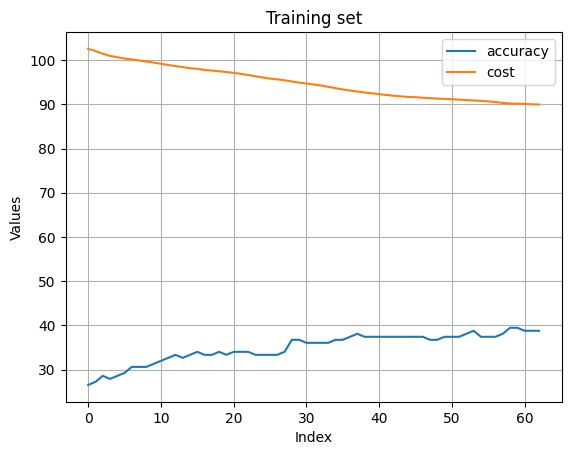

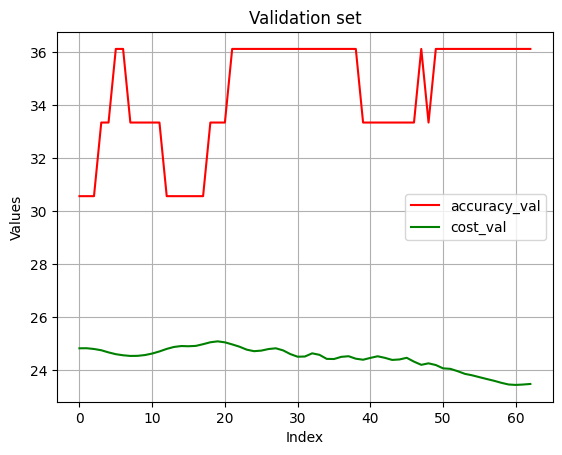

In [ ]:
#plot
import matplotlib.pyplot as plt
accuracy_list_100 = [x * 100 for x in accuracy_list]
accuracy_val_list_100 = [x * 100 for x in accuracy_val_list]
print(len(cost_list), len(cost_val_list), len(accuracy_list), len(accuracy_val_list))
# Plotting a and b in one plot

x_axis = np.arange(len(cost_list))
plt.figure(1)
plt.plot(x_axis, accuracy_list_100, label='accuracy')
plt.plot(x_axis, cost_list, label='cost')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Training set')
plt.legend()
plt.grid(True)

# Plotting c and d in another plot
plt.figure(2)
plt.plot(x_axis, accuracy_val_list_100, label='accuracy_val', color='red')
plt.plot(x_axis, cost_val_list, label='cost_val', color='green')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Validation set')
plt.legend()
plt.grid(True)

# Show the plots
plt.show()


In [ ]:
SRW_obj.w_map.to_csv('test/LUASD_edge_feature_weights_2.txt', sep='\t')

In [ ]:
SRW_obj.w_map

,Weight
Adherens junction,0.006358
Apoptosis,0.073140
B cell receptor signaling pathway,0.001745
BIND,0.507611
Base excision repair,-0.009400
...,...
p53 signaling pathway,0.380567
pid,5.544668
telomere maintenance,-0.056019
selfloop,-1.624404


In [ ]:
import sys


sys.path.append("/content/drive/My Drive/Simulation Group Project1/")

import SRW_v044 as SRW

In [ ]:
SRW_obj.generate_Q_and_P_fin()

In [ ]:
with open('test/SRW_obj_2', 'wb') as output:
    pickle.dump(SRW_obj, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
! pip install pyNBS

In [ ]:
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
SRW_obj.w = SRW_obj.w_list[0]
SRW_obj.map_w()
SRW_obj.w[-1] = 100
SRW_obj.w[-2] = -200
SRW_obj.Q = SRW.generate_Q(SRW_obj.edges, SRW_obj.nnodes, SRW_obj.features, SRW_obj.w)
P = SRW.iterative_PPR(SRW_obj.Q.toarray(), SRW.renorm(SRW_obj.P_init).toarray(), SRW_obj.rst_prob)
SRW_obj.C = SRW_obj.centroid(P, SRW_obj.ngroups, SRW_obj.group2indeces_list)
SRW_obj.calc_cost_and_acc_val()
SRW_obj.generate_Q_and_P_fin()

In [ ]:
P

array([[2.54829273e-04, 1.66624860e-04, 3.11909158e-03, ...,
        1.02630732e-04, 1.65754718e-03, 5.80501655e-04],
       [4.12467406e-04, 6.95715883e-05, 2.36149739e-03, ...,
        8.54400300e-05, 2.23037330e-04, 4.75708875e-04],
       [2.67516455e-04, 1.05568105e-04, 6.26639649e-03, ...,
        3.96840093e-03, 4.02181503e-03, 4.96402287e-03],
       ...,
       [5.17048418e-04, 7.24590581e-05, 2.93099663e-03, ...,
        6.22996369e-04, 1.00926248e-03, 2.27645508e-03],
       [2.56435449e-04, 1.97194869e-04, 8.92182216e-03, ...,
        1.55333768e-04, 1.98201607e-04, 7.77816248e-04],
       [2.46552862e-04, 5.77589523e-03, 2.23218389e-03, ...,
        1.47847454e-04, 2.16794007e-04, 5.90700211e-04]])

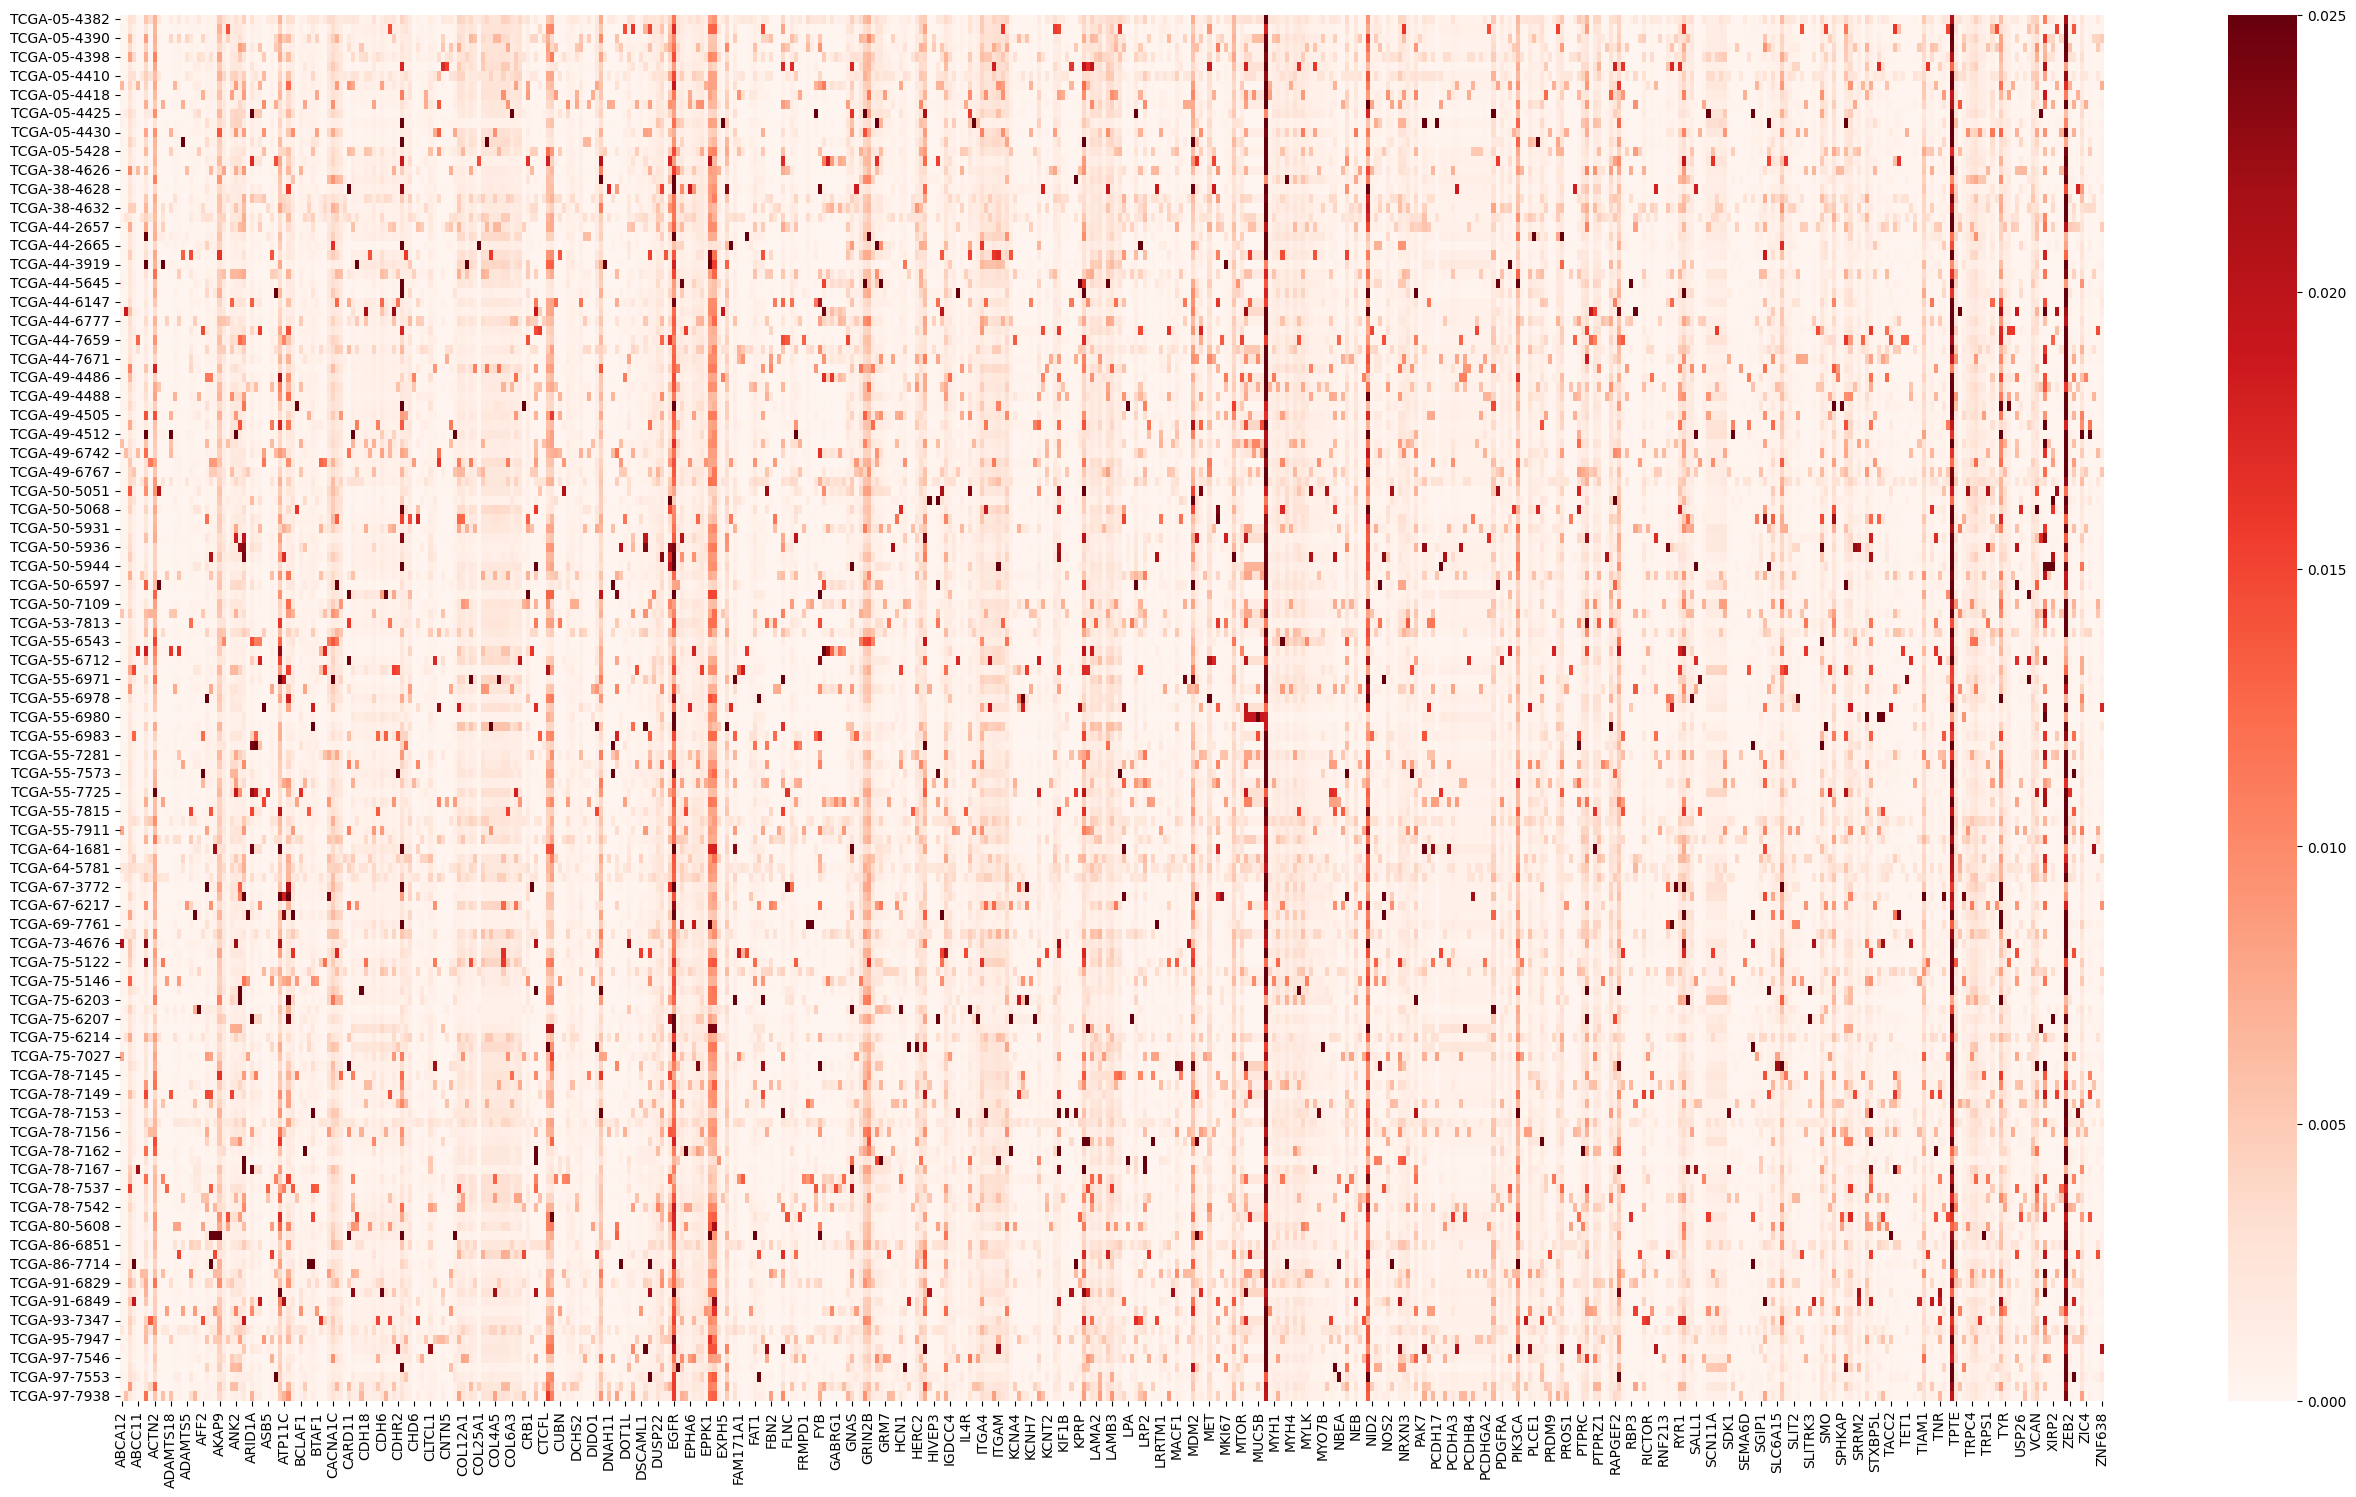

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
P_df = SRW_obj.P_fin_df.copy()
fig, ax = plt.subplots(figsize=(32,18))
ax = sns.heatmap(P_df.clip(upper=0.025),cmap='Reds', square=False)
plt.savefig('test/sim1001000_P_df.pdf')

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

P_df = SRW_obj.P_fin_df.copy()


pca = PCA(n_components=2)
P_df_pca = pca.fit_transform(P_df)


P_df_pca = pd.DataFrame(data=P_df_pca, columns=['PC1', 'PC2'])


In [ ]:
P_df_pca

,PC1,PC2
0,0.001890,0.001861
1,-0.007178,-0.002338
2,-0.005258,0.002222
3,-0.004219,-0.006417
4,-0.003303,0.000116
...,...,...
142,0.003154,-0.002960
143,0.017515,-0.025906
144,-0.051556,-0.052248
145,-0.005019,0.002042


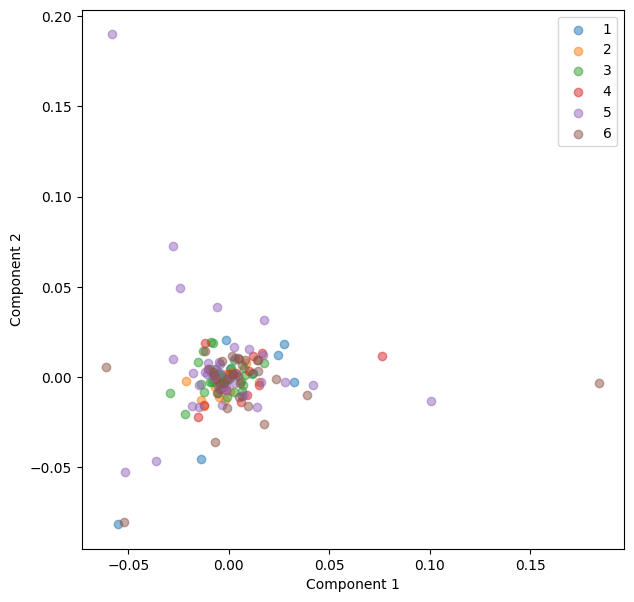

In [ ]:


P_df_pca['labels'] = group_labels_train

labels = P_df_pca.groupby('labels')
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(labels)))

fig, ax = plt.subplots(figsize=(7, 7))
for name, label in labels:
    ax.scatter(label['PC1'], label['PC2'], alpha=0.5, label=name)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='upper right')
plt.show()


In [ ]:
len(group_labels_train)

147

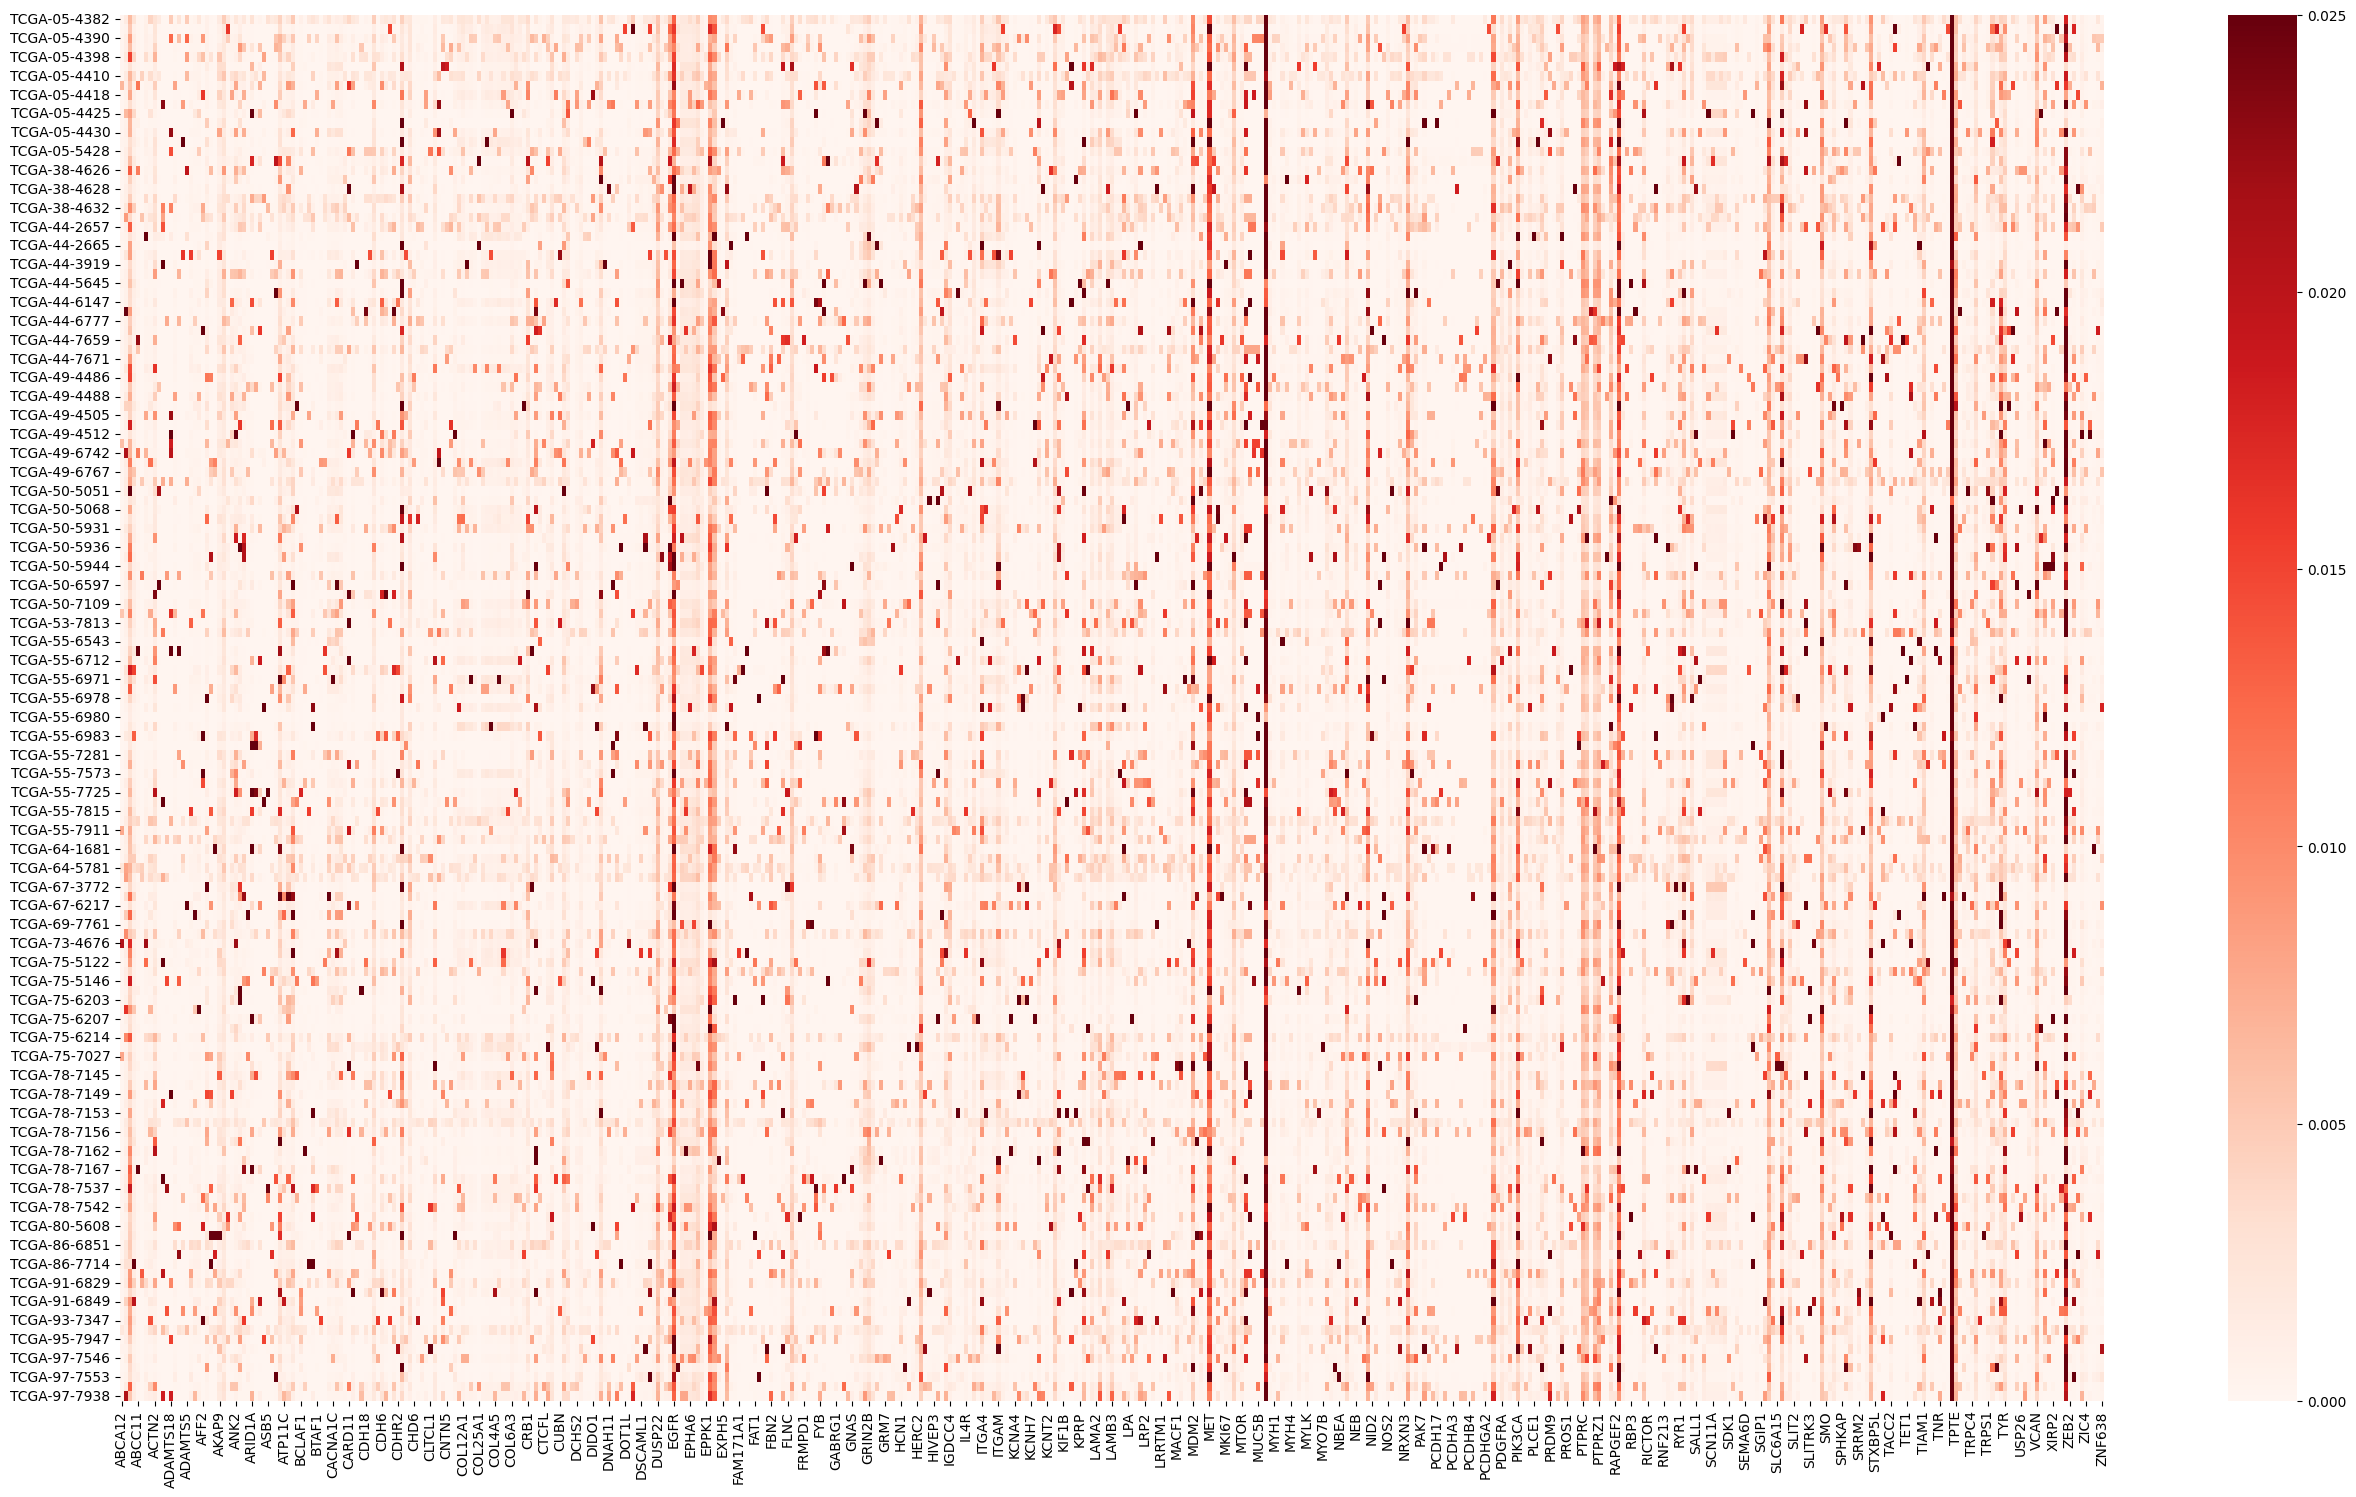

In [ ]:
SRW_obj.w = SRW_obj.w_list[-2]
SRW_obj.map_w()
SRW_obj.Q = SRW.generate_Q(SRW_obj.edges, SRW_obj.nnodes, SRW_obj.features, SRW_obj.w)
P = SRW.iterative_PPR(SRW_obj.Q.toarray(), SRW.renorm(SRW_obj.P_init).toarray(), SRW_obj.rst_prob)
SRW_obj.C = SRW_obj.centroid(P, SRW_obj.ngroups, SRW_obj.group2indeces_list)
SRW_obj.calc_cost_and_acc_val()
SRW_obj.generate_Q_and_P_fin()

P_df = SRW_obj.P_fin_df.copy()
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(32,18))
ax = sns.heatmap(P_df.clip(upper=0.025),cmap='Reds', square=False)
plt.savefig('test/sim1001000_P_df1.pdf')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

P_df = SRW_obj.P_fin_df.copy()


pca = PCA(n_components=2)
P_df_pca = pca.fit_transform(P_df)


P_df_pca = pd.DataFrame(data=P_df_pca, columns=['PC1', 'PC2'])


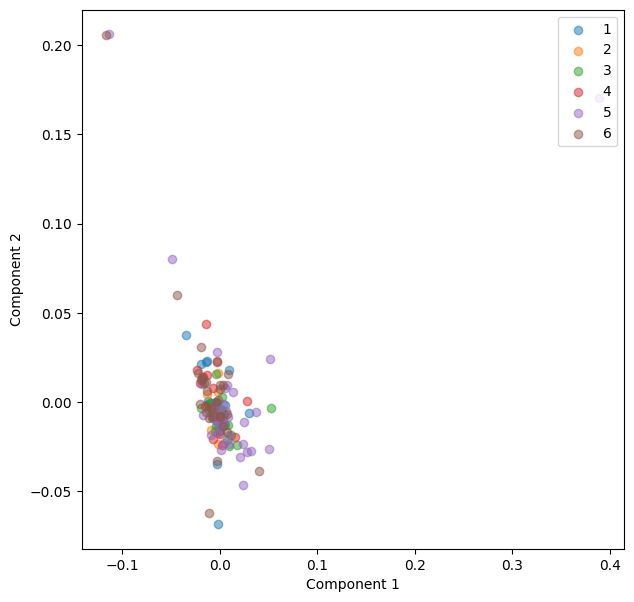

In [ ]:


P_df_pca['labels'] = group_labels_train

labels = P_df_pca.groupby('labels')
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, len(labels)))

fig, ax = plt.subplots(figsize=(7, 7))
for name, label in labels:
    ax.scatter(label['PC1'], label['PC2'], alpha=0.5, label=name)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='upper right')
plt.show()

In [ ]:
SRW_obj.w_list

[array([ 8.49712093e-03, -1.00788925e-02,  2.10056289e-02, -8.29171209e-03,
        -9.29523927e-03, -1.00330836e-02, -3.00937680e-03, -1.78934359e-02,
         1.94502307e-02,  1.17377990e-02,  8.08745802e-03,  8.05310589e-03,
         2.46890981e-02, -1.82241239e-02,  1.38005459e-04,  2.68365383e-03,
         4.11001018e-03, -5.89271405e-03, -4.05690401e-03,  5.29220545e-03,
         1.28212985e-03,  6.71855429e-03, -1.05697135e-02,  1.33031365e-02,
        -5.12621212e-03,  7.03343758e-03, -3.10030430e-03,  1.50316564e-02,
         4.03262954e-03, -6.49798067e-03, -2.91851976e-03,  4.05925775e-03,
         6.75864939e-03, -1.23563336e-03,  1.30912294e-03, -7.65670699e-04,
        -9.21830037e-03, -1.04176037e-02,  1.59764837e-02,  1.97570605e-02,
        -5.40139196e-03, -4.53462697e-03,  2.03885406e-02, -1.07394230e-02,
        -1.53615582e-02, -4.48979890e-03, -4.77958013e-03, -8.75863653e-03,
        -3.18420903e-03,  2.02236641e-02, -8.52464581e-03,  3.77414851e-04,
         1.4